In [1]:
import sys
sys.path.append('..')

from utils.common import read_beacon_coords, read_beacon_data, process_beacon_data_for_strongthree, process_beacon_data_for_pos
import argparse
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pdb

[[{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -62, 'accuracy': 12.296376053275772, 'time': 1724902286523}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -62, 'accuracy': 12.296376053275772, 'time': 1724902286620}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -68, 'accuracy': 29.992573490350974, 'time': 1724902286620}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -65, 'accuracy': 19.345173789319468, 'time': 1724902286721}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -68, 'accuracy': 29.992573490350974, 'time': 1724902286721}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -65, 'accuracy': 19.345173789319468, 'time': 1724902286821}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -67, 'accuracy': 25.958067100628753, 'time': 1724902286821}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -71, 'accuracy': 45.78640352029778, 'time': 1724902286922}, {'uuid': '0f3c0000-0000-0000-0000-000000000000'

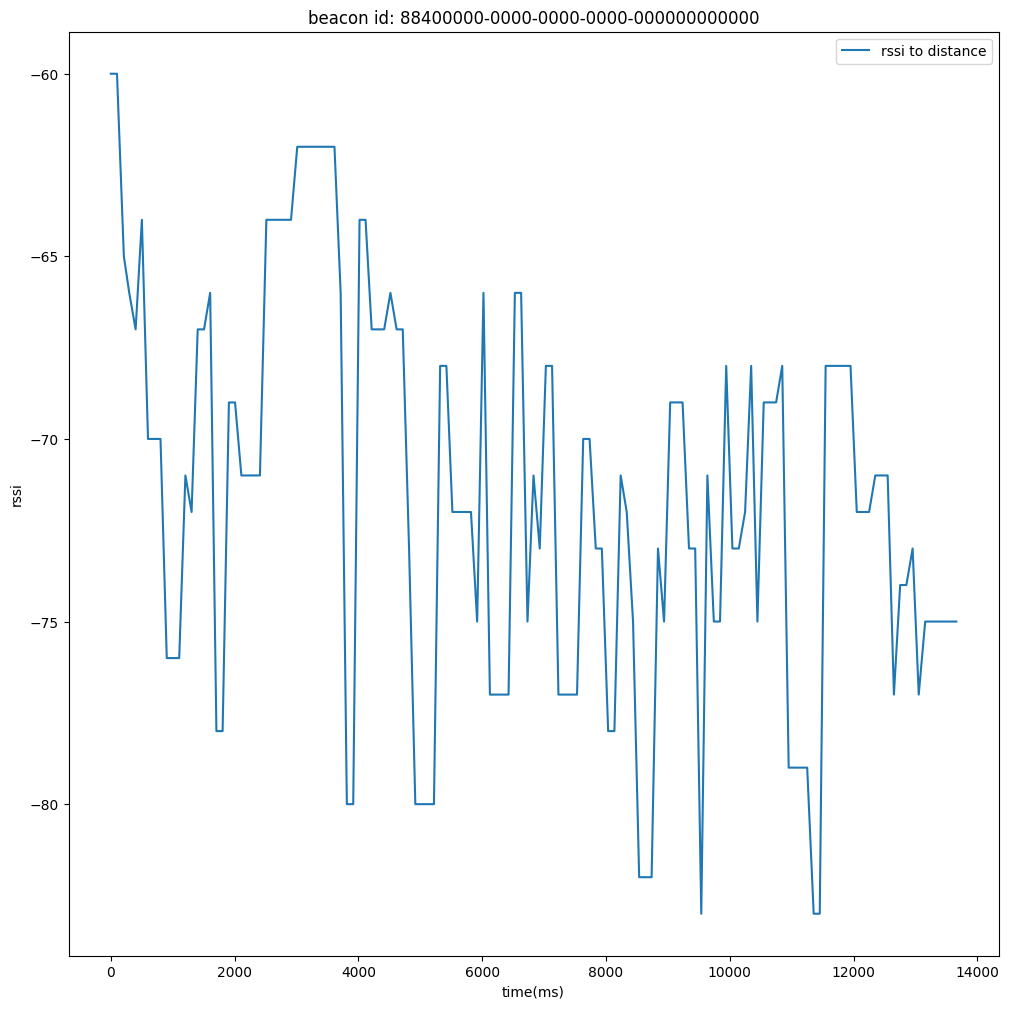

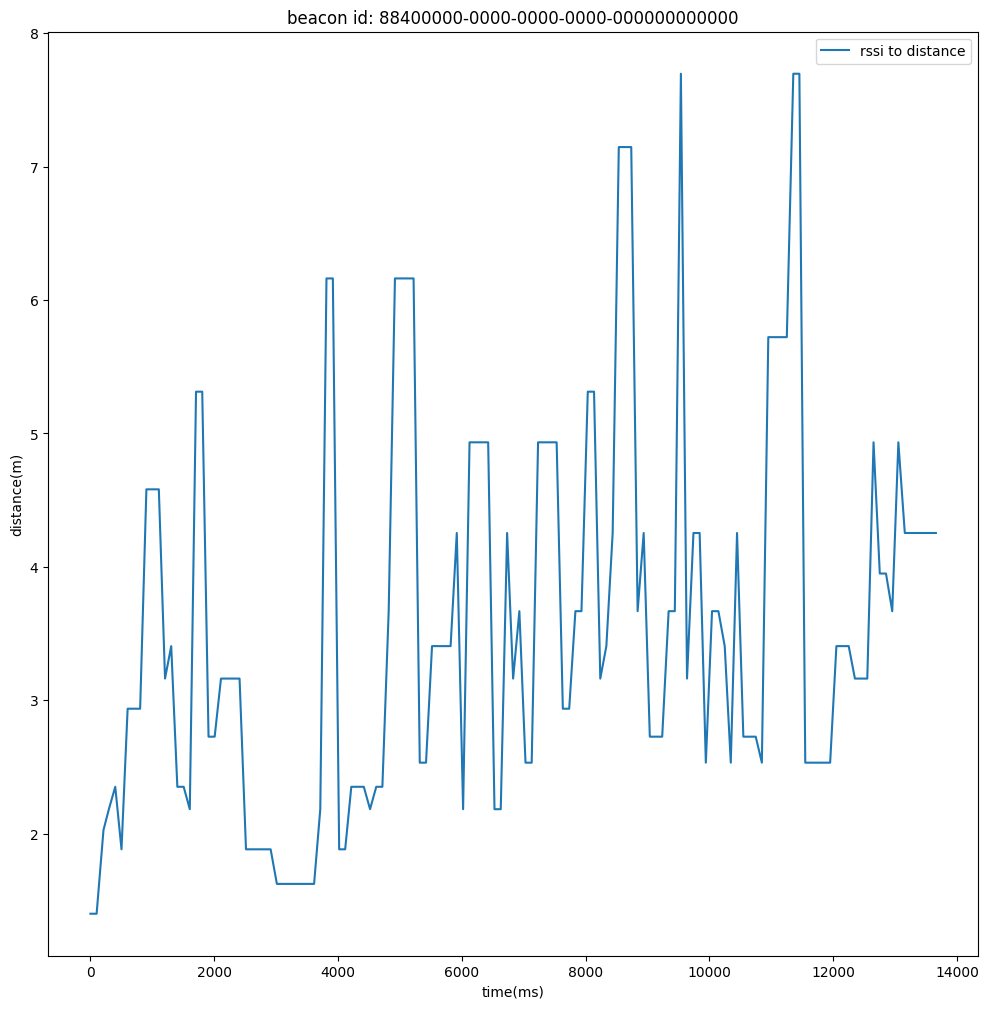

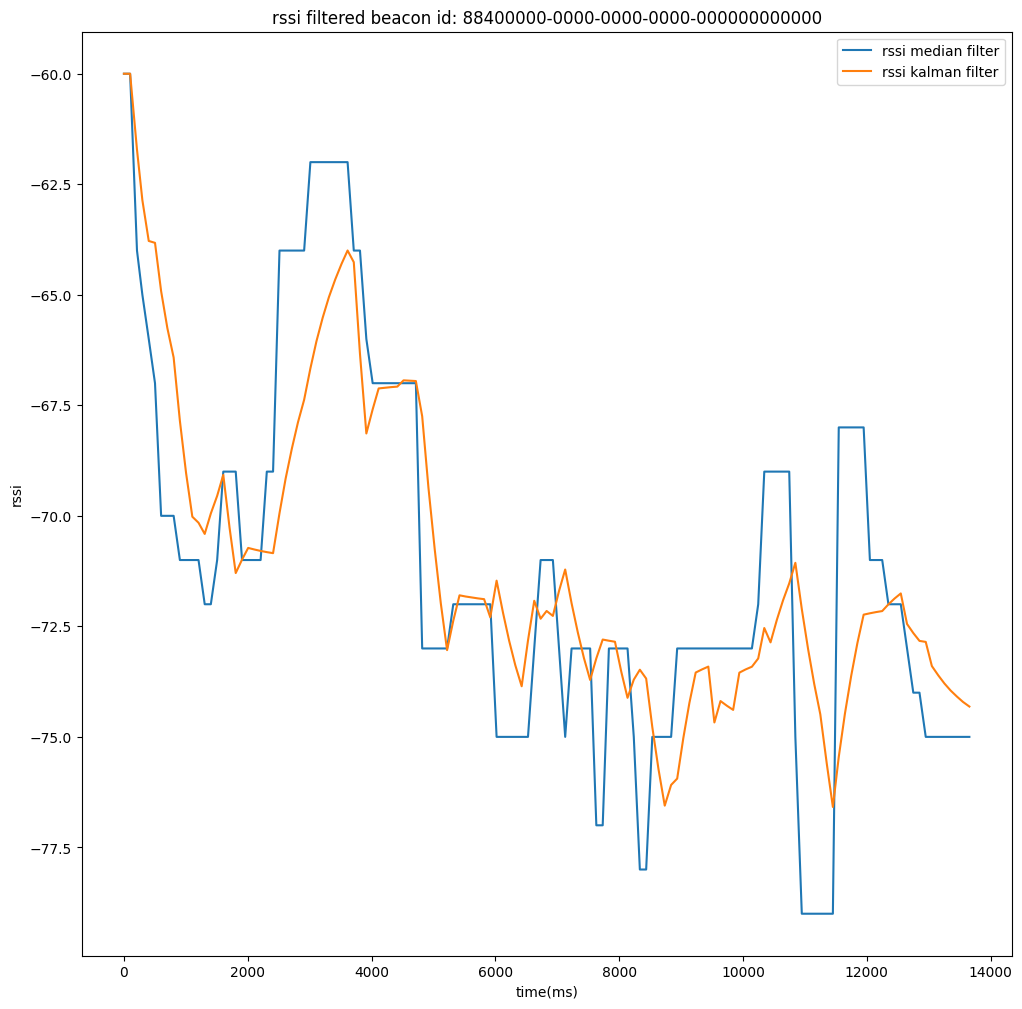

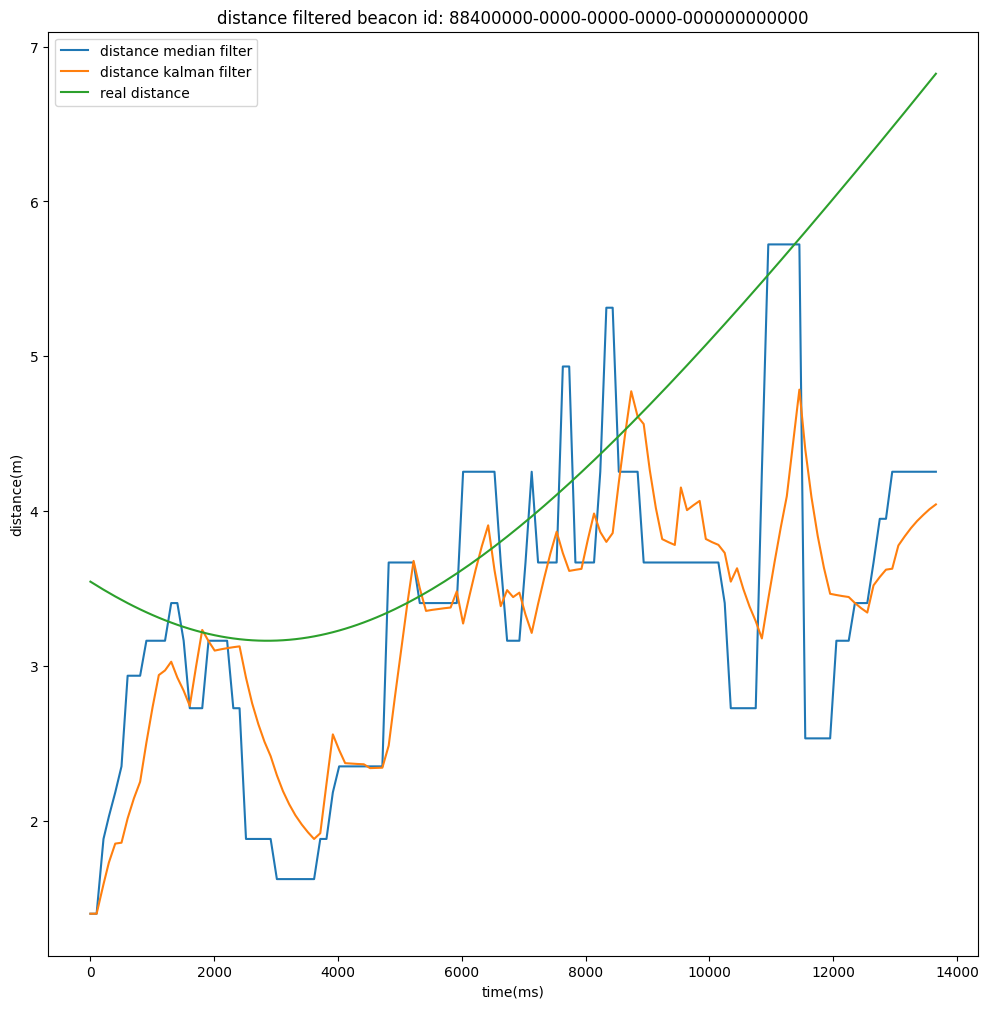

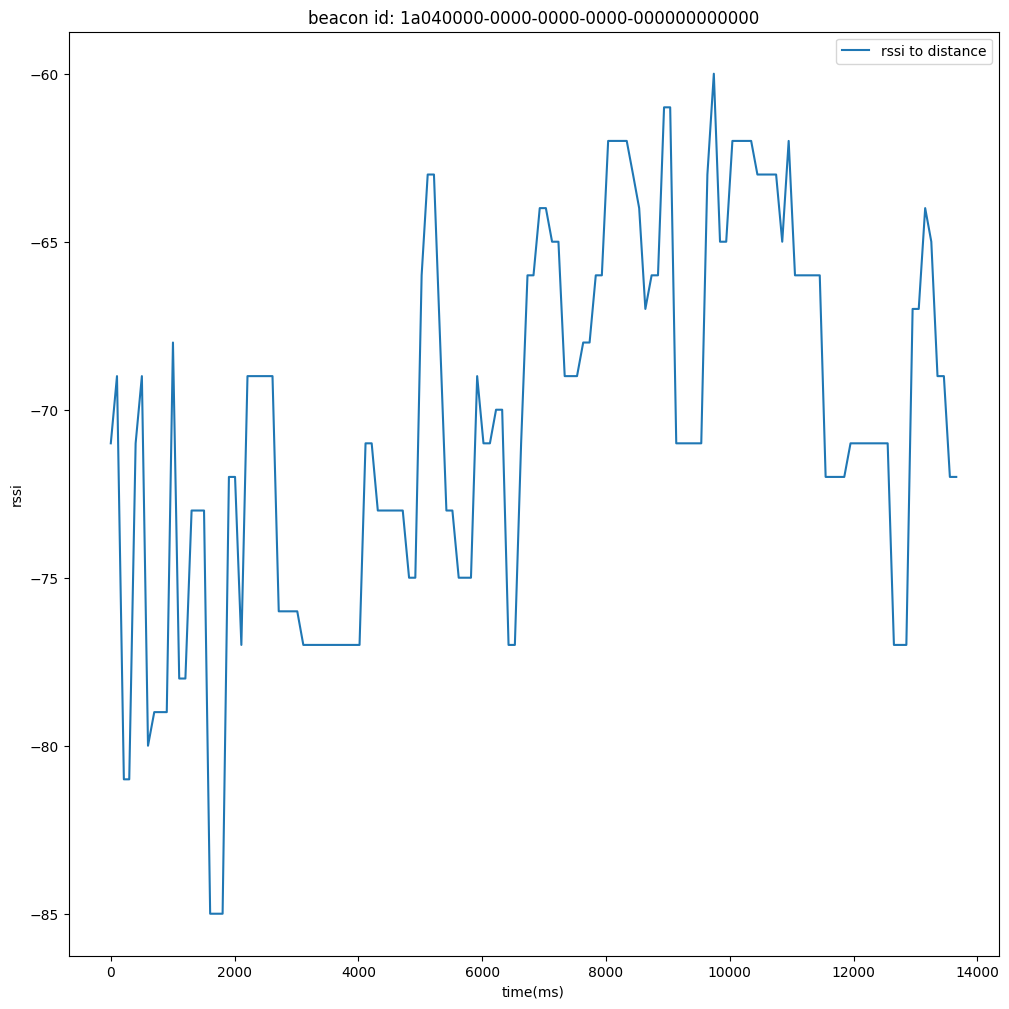

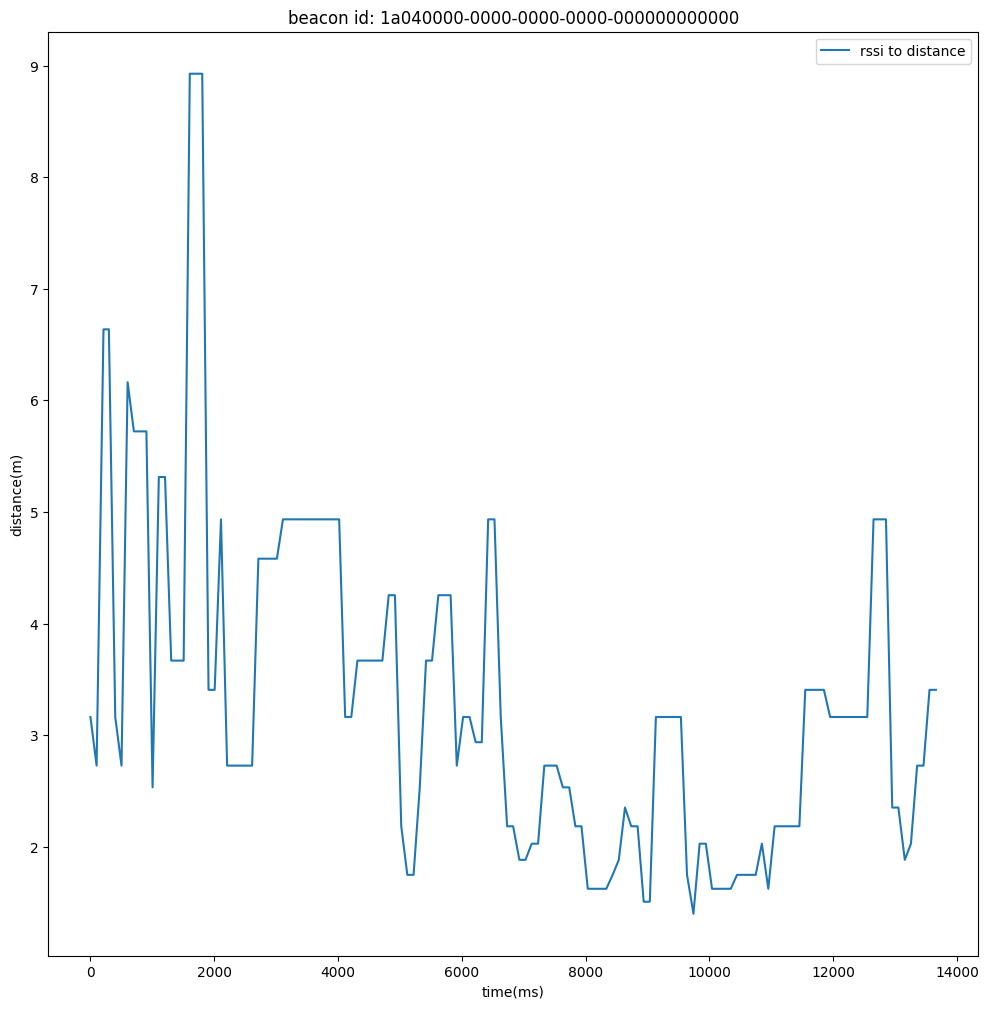

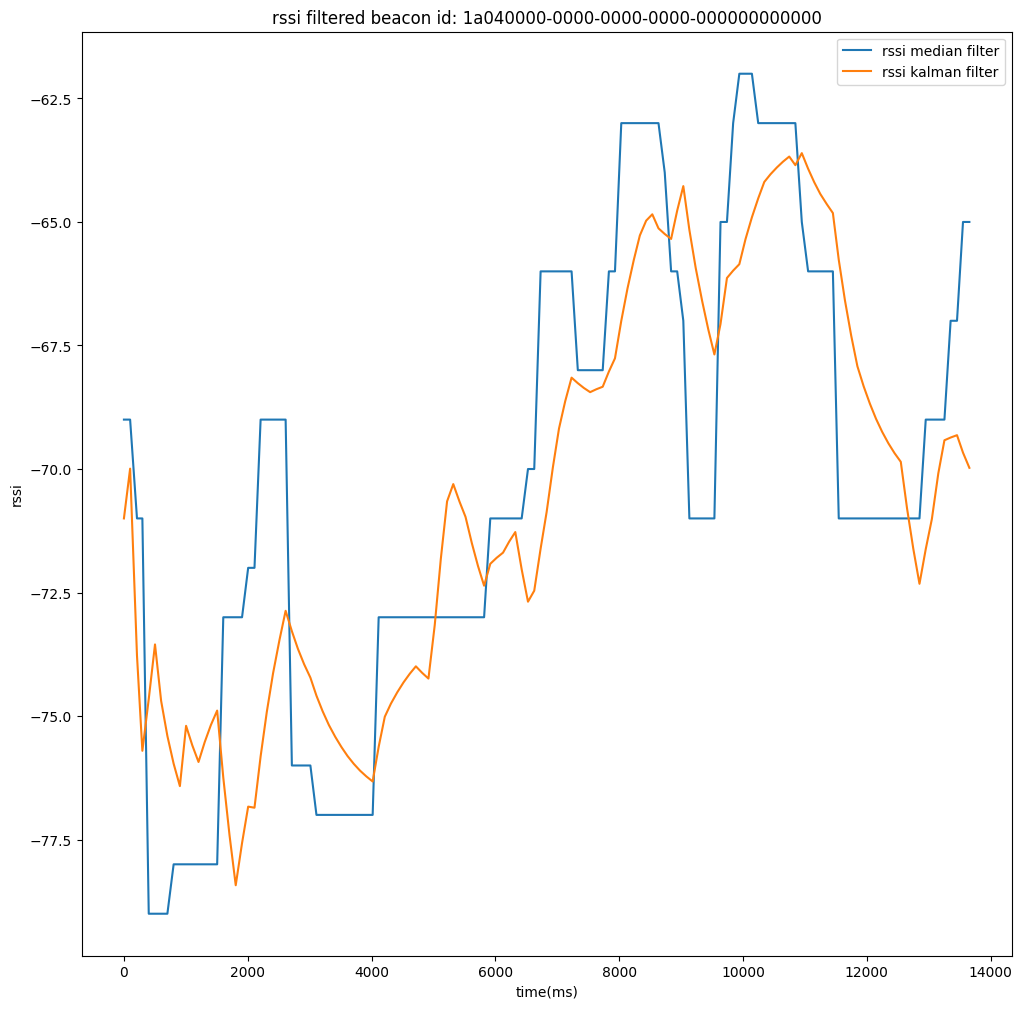

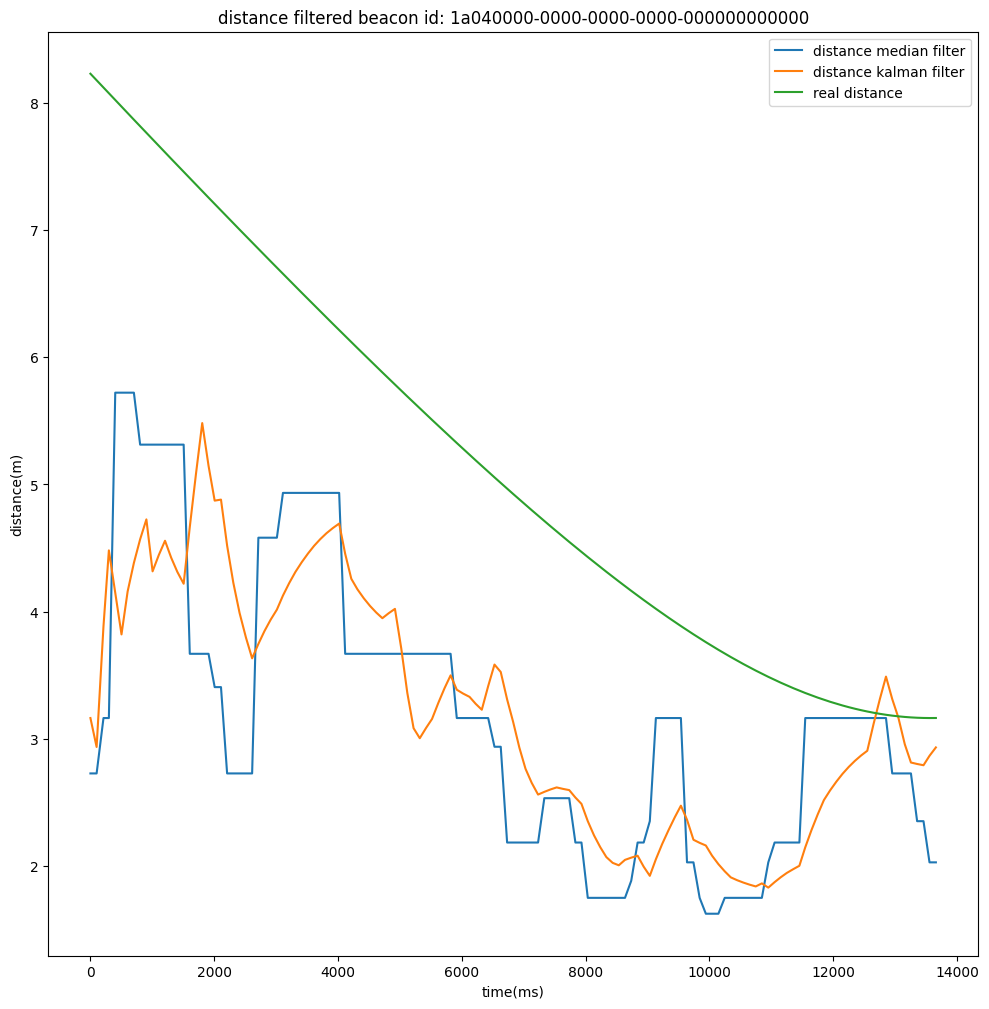

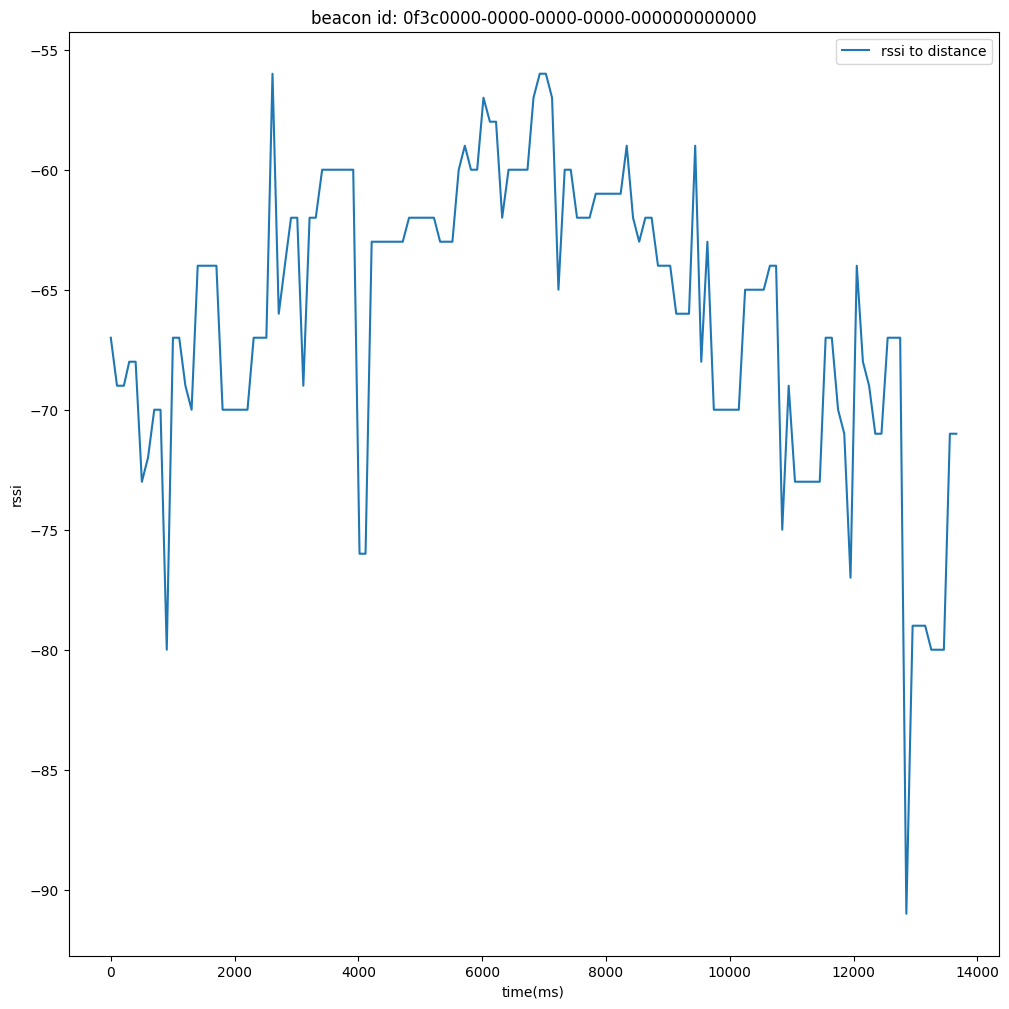

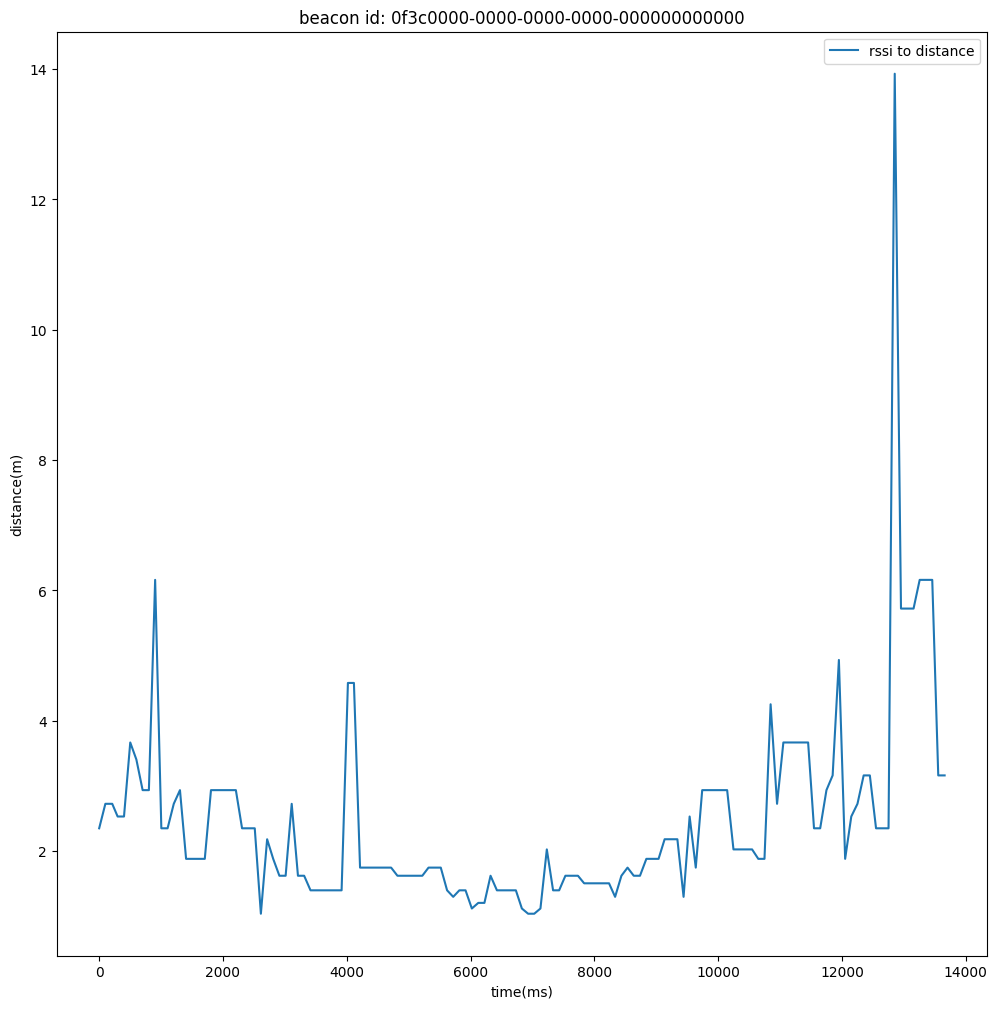

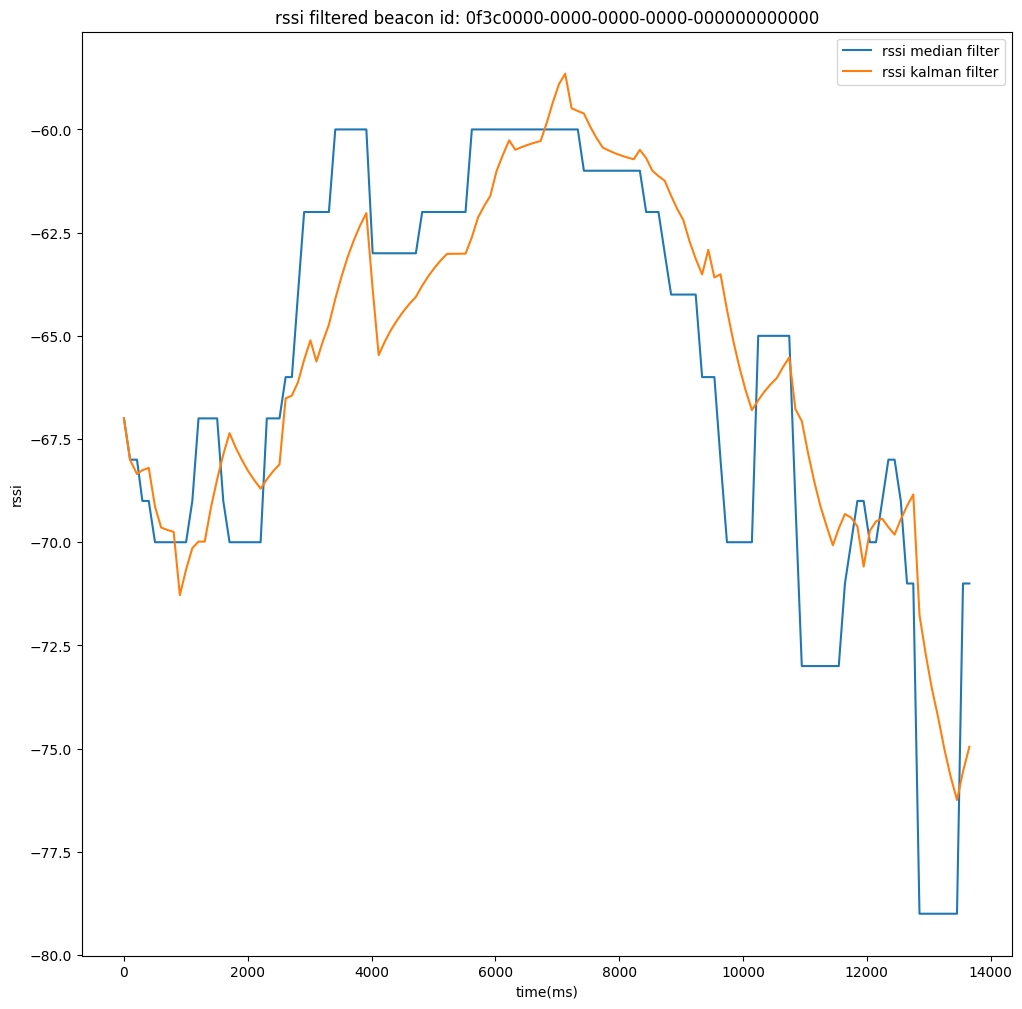

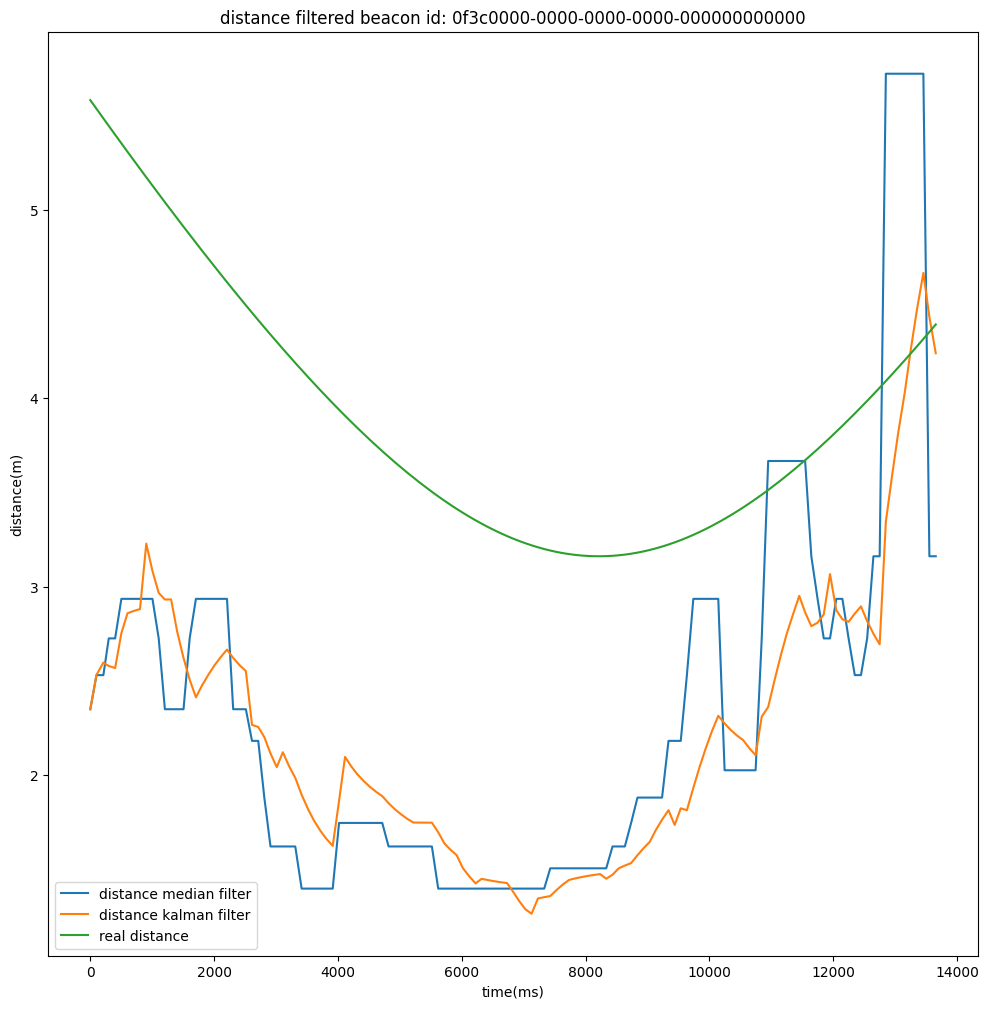

In [2]:
# visualize the beacon RSSI to distance
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pdb
from scipy.signal import medfilt
from filterpy.kalman import KalmanFilter


args = argparse.Namespace(beacon_coords_file='../data0829ad/beacon_coords.txt', beacon_data_dir='../data0829ad/', beacon_data_file='../data0829ad/bluetoothData(84).txt', update_frequency=10)

beacon_data = read_beacon_data(args.beacon_data_file)

def apply_average_filter(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def apply_median_filter(data, window_size=9):
    return medfilt(data, kernel_size=window_size)

def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([data[0]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = 0.1
    kf.H = np.array([[1.]])
    kf.F = np.array([[1.]])
    
    filtered_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        filtered_data.append(kf.x[0])
    return filtered_data

def rssi_to_distance(rssi):
    txPower = -55.47
    n = 3.106
    return 10 ** ((txPower - rssi) / (10 * n))



x0, y0 = 3.0, -1.6
v = 0.00056


beacon_id_to_rssi = defaultdict(list)
time_stamp = []
print(beacon_data)
for beacon_group in beacon_data:
    if len(beacon_group) < 3:
        print("beacon group length is less than 3")
        continue
    for beacon in beacon_group:
        beacon_id = beacon['uuid']
        beacon_id_to_rssi[beacon_id].append(beacon['rssi'])
    time_stamp.append(beacon['time'])

time_stamp = np.array(time_stamp) - time_stamp[0]
d1 = np.sqrt(x0**2 + (y0 + v * time_stamp)**2 + 1.0)
d2 = np.sqrt(x0**2 + (6.0 -y0 - v * time_stamp)**2 + 1.0)
d3 = np.sqrt((x0 - 6.0)**2 + (3 - y0 - v * time_stamp)**2 + 1.0)
ds = [d1, d2, d3]
print("total time interval: ", time_stamp[-1] - time_stamp[0])
for i, (beacon_id, rssi_values) in enumerate(beacon_id_to_rssi.items()):
    if len(beacon_group[0]) <= 3:
        print("beacon group length is less than 3")
        continue
    plt.figure(figsize=(12, 12))
    distance = [rssi_to_distance(rssi) for rssi in rssi_values]
    plt.plot(time_stamp, rssi_values, label='rssi to distance')
    plt.xlabel('time(ms)')
    plt.ylabel('rssi')
    plt.legend()
    plt.title('beacon id: {}'.format(beacon_id))
    plt.show()
    
    plt.figure(figsize=(12, 12))
    plt.plot(time_stamp, distance, label='rssi to distance')
    plt.xlabel('time(ms)')
    plt.ylabel('distance(m)')
    plt.title('beacon id: {}'.format(beacon_id))
    plt.legend()
    plt.show()
    
    rssi_median_filtered = apply_median_filter(rssi_values)
    rssi_kalman_filtered = apply_kalman_filter(rssi_values)
    plt.figure(figsize=(12, 12))
    plt.plot(time_stamp, rssi_median_filtered, label='rssi median filter')
    plt.plot(time_stamp, rssi_kalman_filtered, label='rssi kalman filter')
    # plt.plot(time_stamp, d, label='real distance')
    plt.xlabel('time(ms)')
    plt.ylabel('rssi')
    plt.legend()
    plt.title('rssi filtered beacon id: {}'.format(beacon_id))
    plt.show()
    
    
    distance_median_filtered = [rssi_to_distance(rssi) for rssi in rssi_median_filtered]
    distance_kalman_filtered = [rssi_to_distance(rssi) for rssi in rssi_kalman_filtered]
    plt.figure(figsize=(12, 12))
    plt.plot(time_stamp, distance_median_filtered, label='distance median filter')
    plt.plot(time_stamp, distance_kalman_filtered, label='distance kalman filter')
    plt.plot(time_stamp, ds[i], label='real distance')
    plt.xlabel('time(ms)')
    plt.ylabel('distance(m)')
    plt.title('distance filtered beacon id: {}'.format(beacon_id))
    plt.legend()
    plt.show()


beacon data [[{'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -71, 'accuracy': 45.78640352029778, 'time': 1724902517120}], [{'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -69, 'accuracy': 34.59438414037775, 'time': 1724902517214}], [{'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -70, 'accuracy': 39.833273094050156, 'time': 1724902517317}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -70, 'accuracy': 39.833273094050156, 'time': 1724902517418}, {'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -67, 'accuracy': 25.958067100628753, 'time': 1724902517418}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -64, 'accuracy': 16.658868643737616, 'time': 1724902517418}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -70, 'accuracy': 39.833273094050156, 'time': 1724902517519}, {'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -67, 'accuracy': 25.958067100628753, 'time': 1724902517519}, {'uuid': '0f3c0000-0000-0000-0000-00

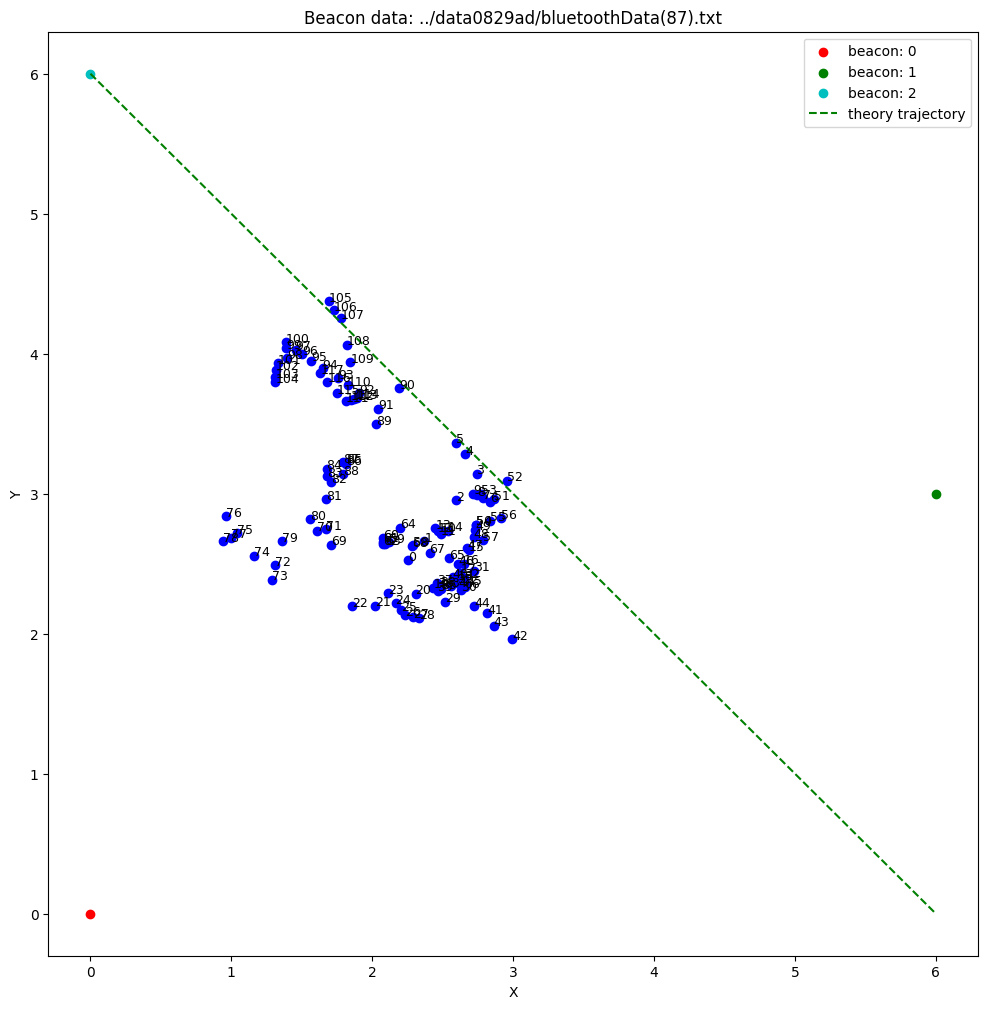

positions [array([[2.25138511],
       [2.52690609],
       [0.81891898]]), array([[2.36894591],
       [2.6588538 ],
       [0.86168055]]), array([[2.59588793],
       [2.95534733],
       [0.88121862]]), array([[2.74018337],
       [3.1440406 ],
       [0.89337714]]), array([[2.65838002],
       [3.28159   ],
       [0.90073658]]), array([[2.59683983],
       [3.3634529 ],
       [0.90478931]]), array([[2.83642395],
       [2.94175922],
       [0.90677225]]), array([[2.78367366],
       [2.96986155],
       [0.90755844]]), array([[2.74539723],
       [2.98792576],
       [0.9076847 ]]), array([[2.71767754],
       [2.99935317],
       [0.90746031]]), array([[2.48810613],
       [2.73119432],
       [0.90705836]]), array([[2.48874044],
       [2.70899979],
       [0.90657701]]), array([[2.46450714],
       [2.73401797],
       [0.9060687 ]]), array([[2.44815769],
       [2.75248124],
       [0.90556378]]), array([[2.53661346],
       [2.73539812],
       [0.90507649]]), array([[2.6833

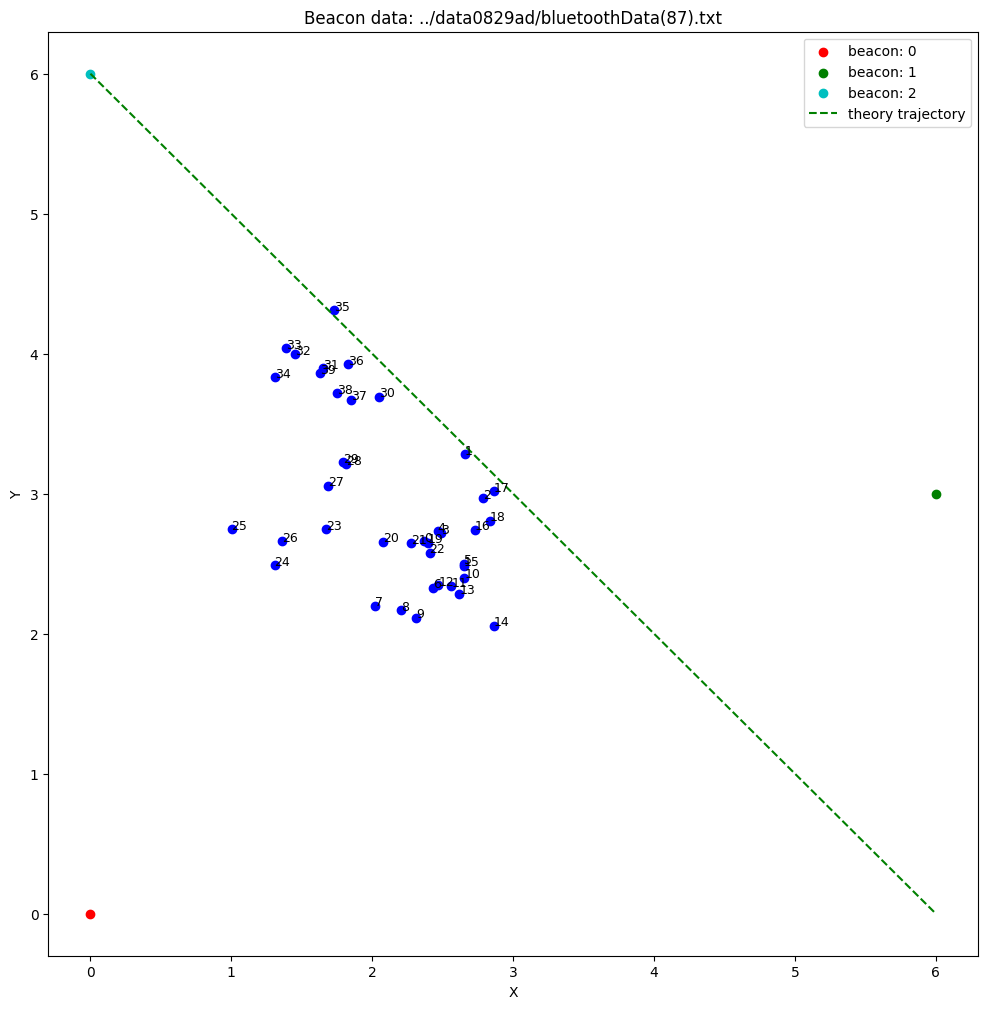

beacon data [[{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -62, 'accuracy': 12.296376053275772, 'time': 1724902286523}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -62, 'accuracy': 12.296376053275772, 'time': 1724902286620}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -68, 'accuracy': 29.992573490350974, 'time': 1724902286620}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -65, 'accuracy': 19.345173789319468, 'time': 1724902286721}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -68, 'accuracy': 29.992573490350974, 'time': 1724902286721}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -65, 'accuracy': 19.345173789319468, 'time': 1724902286821}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -67, 'accuracy': 25.958067100628753, 'time': 1724902286821}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -71, 'accuracy': 45.78640352029778, 'time': 1724902286922}, {'uuid': '0f3c0000-0000-0000-0000-0

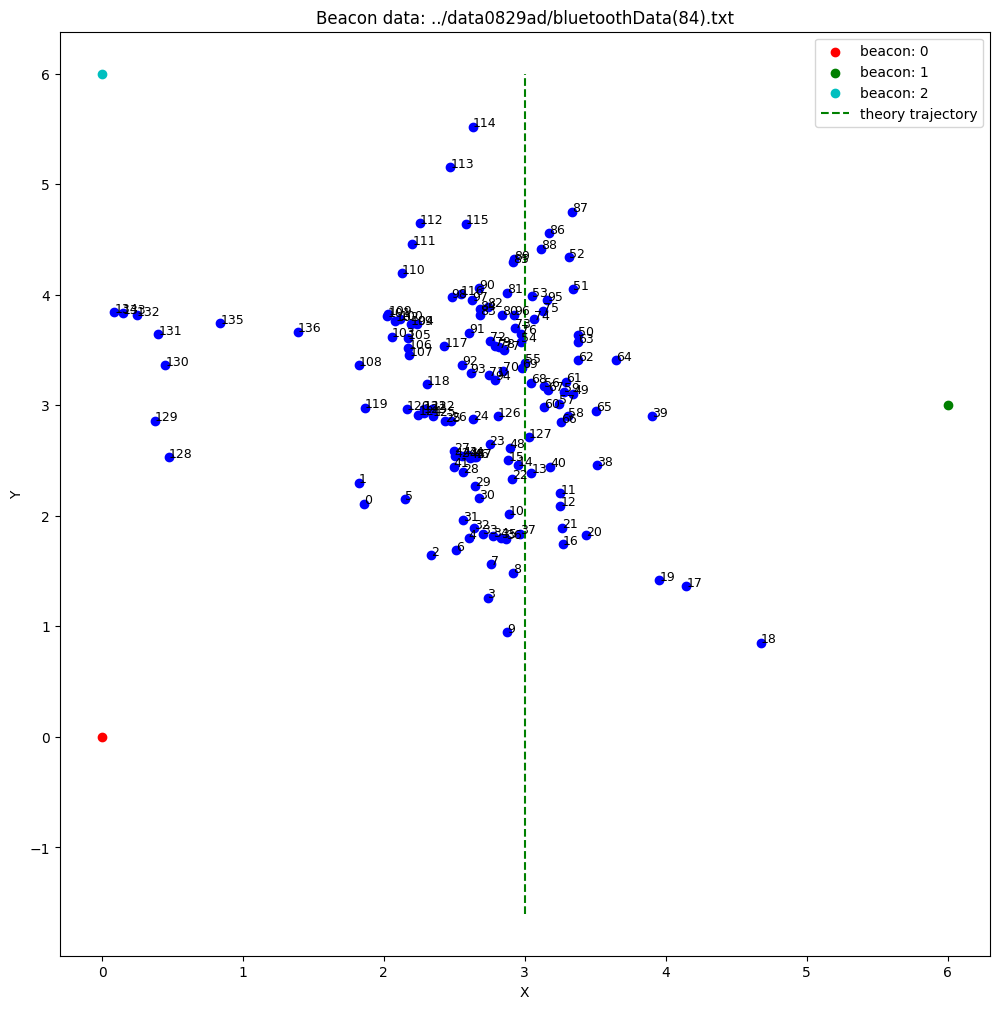

positions [array([[1.8590534 ],
       [2.1088079 ],
       [0.81891896]]), array([[1.82105131],
       [2.29930133],
       [0.861662  ]]), array([[2.33641284],
       [1.64286955],
       [0.88118766]]), array([[2.73585982],
       [1.26050805],
       [0.89334627]]), array([[2.60114148],
       [1.7955104 ],
       [0.9007169 ]]), array([[2.15332716],
       [2.15175622],
       [0.90476981]]), array([[2.50933984],
       [1.68869993],
       [0.90675469]]), array([[2.75882326],
       [1.56514663],
       [0.90754115]]), array([[2.91937465],
       [1.48618843],
       [0.90767033]]), array([[2.8770891 ],
       [0.94626981],
       [0.9862333 ]]), array([[2.88533924],
       [2.01229579],
       [0.96202767]]), array([[3.2528745 ],
       [2.20399517],
       [0.94486323]]), array([[3.25187933],
       [2.09167087],
       [0.93259681]]), array([[3.04627199],
       [2.38947617],
       [0.92378517]]), array([[2.95197707],
       [2.45859399],
       [0.91741278]]), array([[2.8828

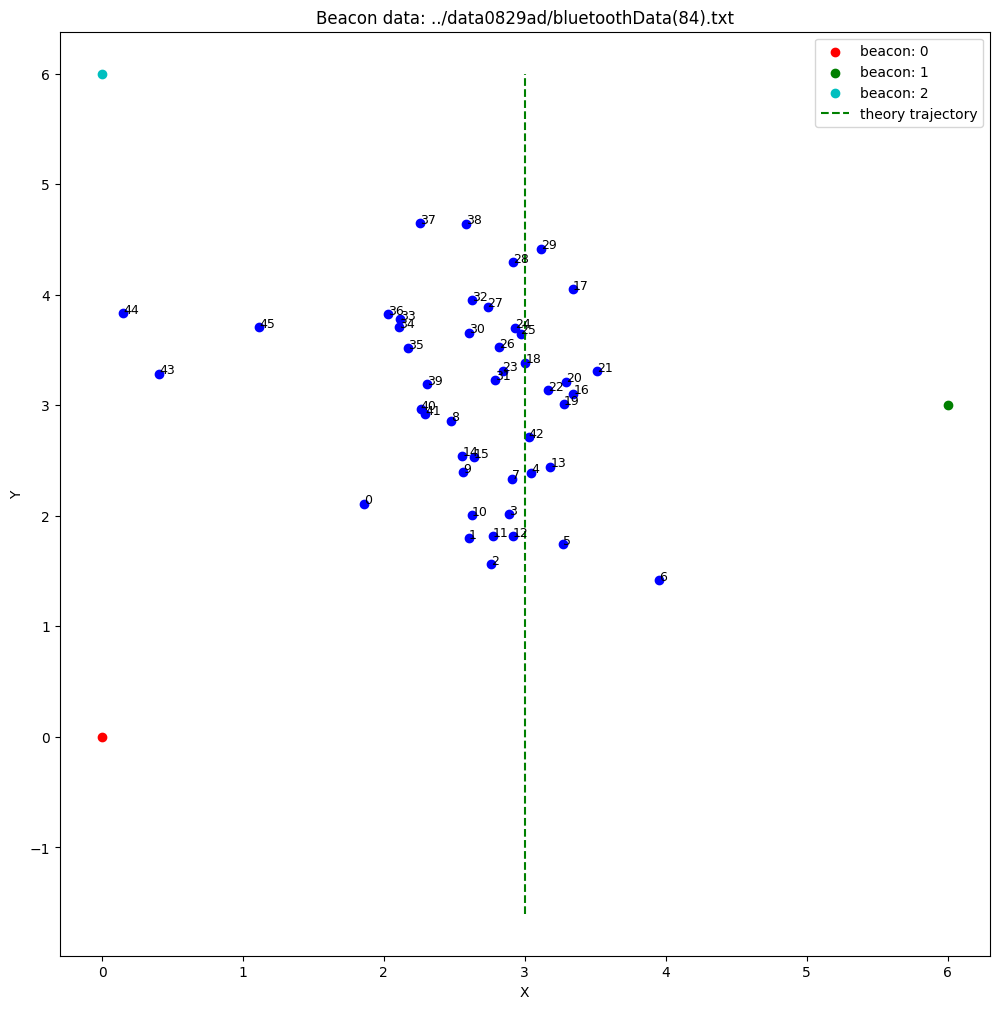

beacon data [[{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -70, 'accuracy': 39.833273094050156, 'time': 1724902440031}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -70, 'accuracy': 39.833273094050156, 'time': 1724902440131}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -70, 'accuracy': 39.833273094050156, 'time': 1724902440233}, {'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -46, 'accuracy': 0.6533801602200308, 'time': 1724902440233}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -87, 'accuracy': 342.11463903347766, 'time': 1724902440233}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -70, 'accuracy': 39.833273094050156, 'time': 1724902440334}, {'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -53, 'accuracy': 3.0177652788769516, 'time': 1724902440334}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -70, 'accuracy': 39.833273094050156, 'time': 1724902440334}], [{'uuid': '1a040000-0000-0000-0000-

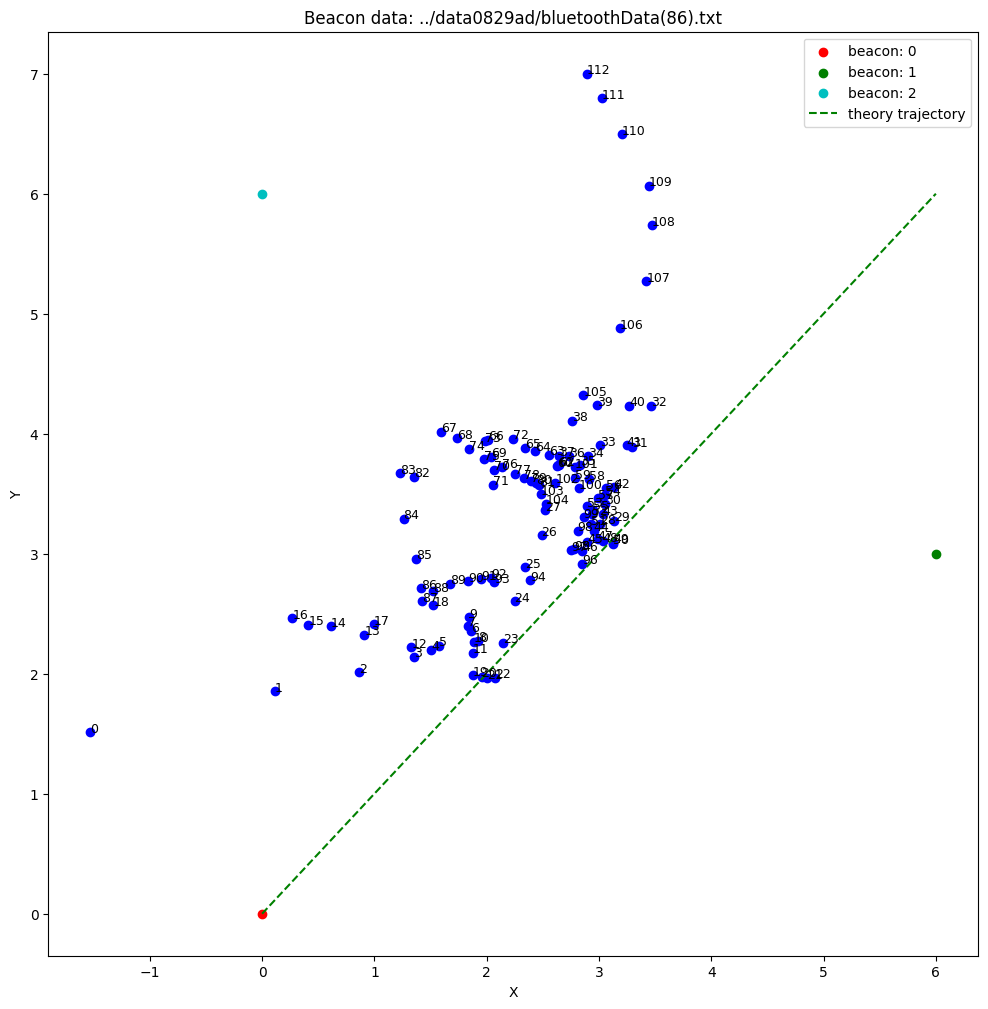

positions [array([[-1.52876505],
       [ 1.51240725],
       [ 0.81891901]]), array([[0.11266613],
       [1.85485254],
       [0.86167498]]), array([[0.86205216],
       [2.01121229],
       [0.88120356]]), array([[1.35297307],
       [2.14200841],
       [0.89336249]]), array([[1.50661777],
       [2.20121378],
       [0.90073244]]), array([[1.57625075],
       [2.23311533],
       [0.90478881]]), array([[1.86450065],
       [2.35447793],
       [0.90676816]]), array([[1.83607537],
       [2.39980101],
       [0.90756074]]), array([[1.92344028],
       [2.27619987],
       [0.90768549]]), array([[1.84593734],
       [2.46853853],
       [0.90746086]]), array([[1.88360868],
       [2.26603878],
       [0.90705732]]), array([[1.87901827],
       [2.17447405],
       [0.9065761 ]]), array([[1.3290552 ],
       [2.21985139],
       [0.97936265]]), array([[0.9090956 ],
       [2.3249171 ],
       [0.95747649]]), array([[0.6141803 ],
       [2.39714375],
       [0.94170159]]), array([[0.4

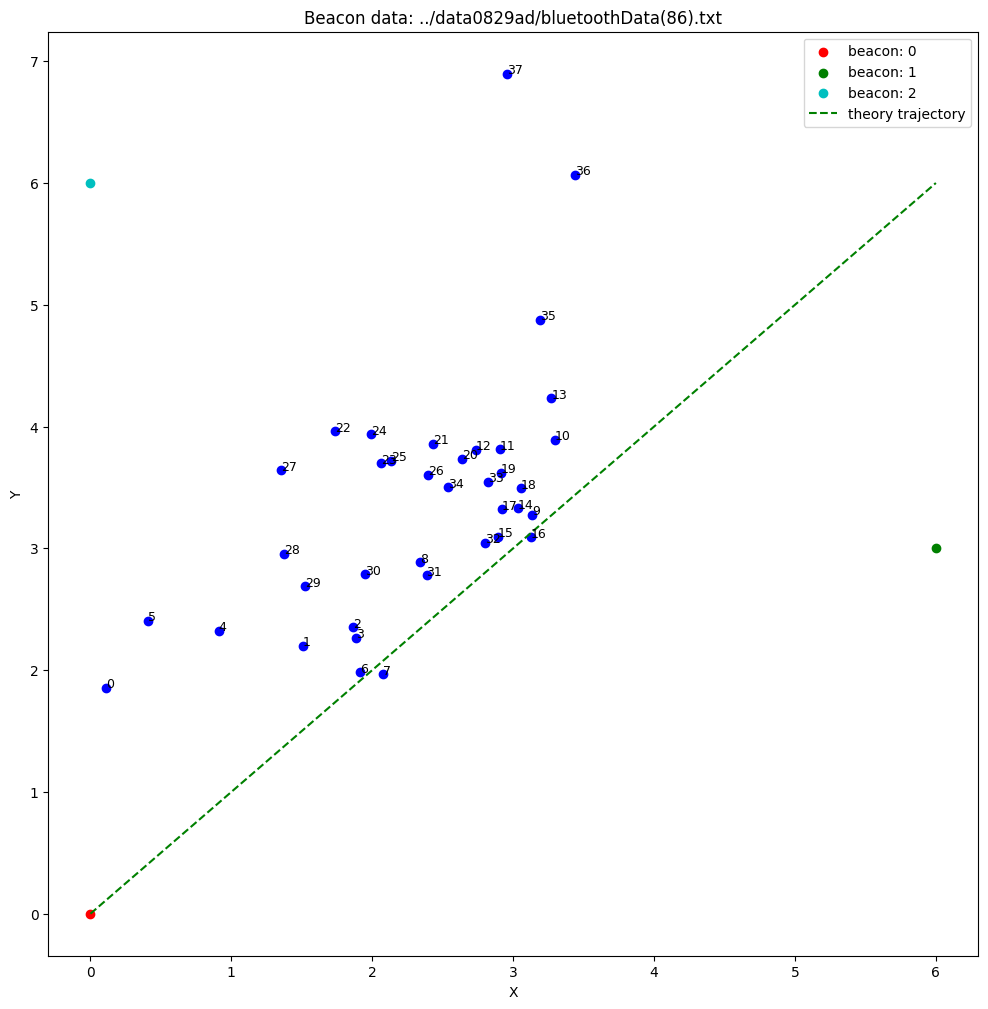

beacon data [[{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -71, 'accuracy': 45.78640352029778, 'time': 1724902373939}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -81, 'accuracy': 168.33636078435438, 'time': 1724902373939}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -71, 'accuracy': 45.78640352029778, 'time': 1724902374036}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -81, 'accuracy': 168.33636078435438, 'time': 1724902374036}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -68, 'accuracy': 29.992573490350974, 'time': 1724902374136}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -67, 'accuracy': 25.958067100628753, 'time': 1724902374136}], [{'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -66, 'accuracy': 22.427865743036918, 'time': 1724902374237}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -67, 'accuracy': 25.958067100628753, 'time': 1724902374237}], [{'uuid': '1a040000-0000-0000-0000-00

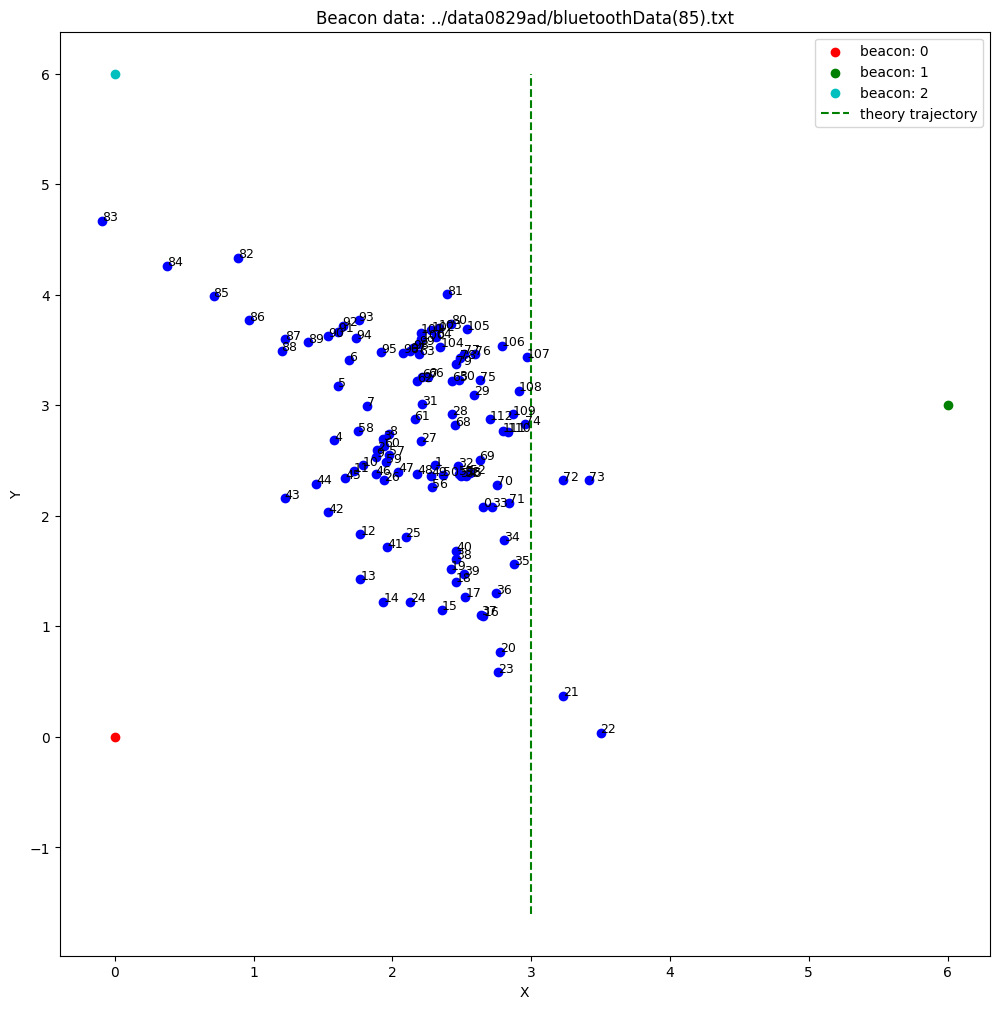

positions [array([[2.65483849],
       [2.08333779],
       [0.81891898]]), array([[2.30661479],
       [2.45994859],
       [0.86167781]]), array([[1.89136191],
       [2.593632  ],
       [0.88121042]]), array([[1.93261663],
       [2.69359699],
       [0.89337693]]), array([[1.58141814],
       [2.68449874],
       [0.90073881]]), array([[1.6067449 ],
       [3.17087072],
       [0.90479319]]), array([[1.68796048],
       [3.40642756],
       [0.9067712 ]]), array([[1.81878575],
       [2.99686684],
       [0.90755353]]), array([[1.97689438],
       [2.73749039],
       [0.90768381]]), array([[1.88119429],
       [2.53501422],
       [0.90745998]]), array([[1.78654905],
       [2.45736618],
       [0.90705945]]), array([[1.72339581],
       [2.40534622],
       [0.90657664]]), array([[1.76881123],
       [1.83251321],
       [0.90606893]]), array([[1.77030825],
       [1.42593486],
       [0.90556191]]), array([[1.93402973],
       [1.2220931 ],
       [0.90507388]]), array([[2.3543

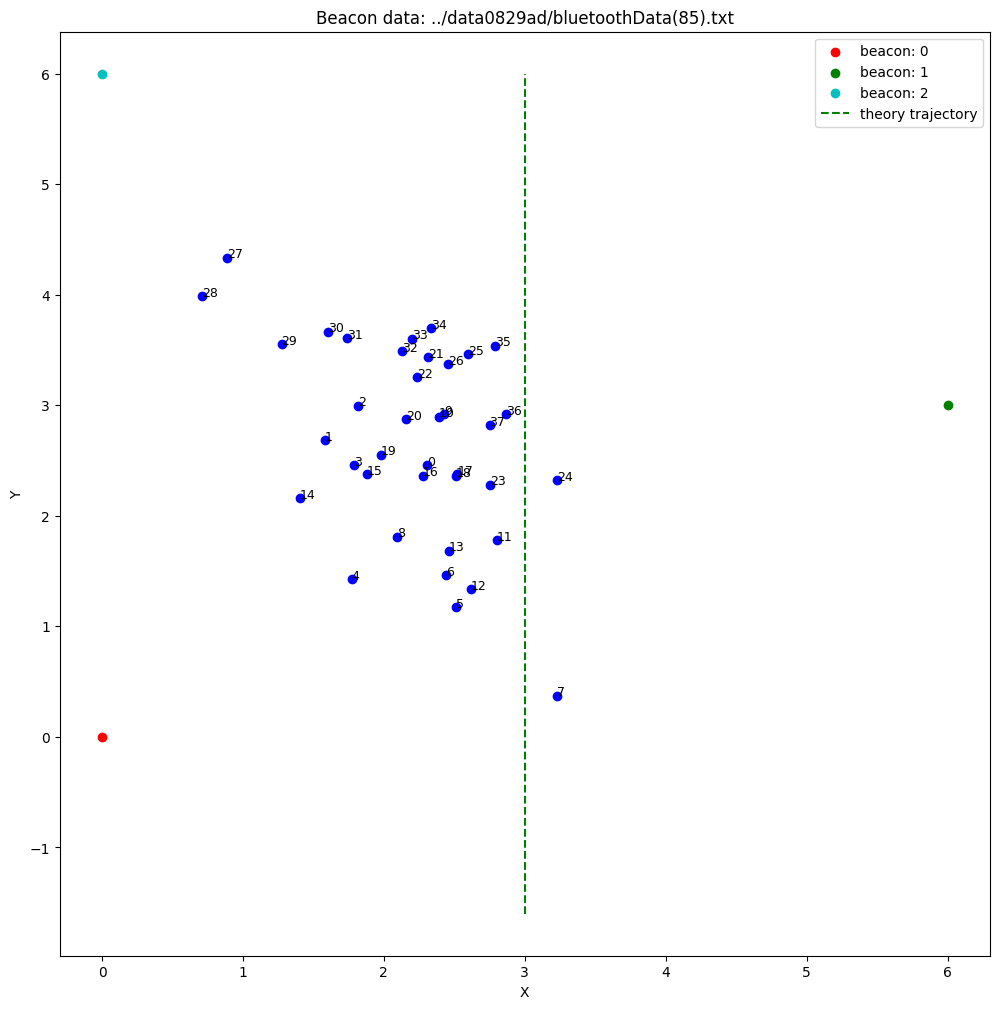

beacon data {'88400000-0000-0000-0000-000000000000': {'x': 0, 'y': 0, 'z': 0}, '0f3c0000-0000-0000-0000-000000000000': {'x': 6, 'y': 3, 'z': 0}, '1a040000-0000-0000-0000-000000000000': {'x': 0, 'y': 6, 'z': 0}}
beacon group num 3
../data0829ad/beacon_coords.txt
beacon_data {'88400000-0000-0000-0000-000000000000': {'x': 0, 'y': 0, 'z': 0}, '0f3c0000-0000-0000-0000-000000000000': {'x': 6, 'y': 3, 'z': 0}, '1a040000-0000-0000-0000-000000000000': {'x': 0, 'y': 6, 'z': 0}}
Error: At least 3 beacons are required to determine position
Error: At least 3 beacons are required to determine position
Error: At least 3 beacons are required to determine position
len positions 0


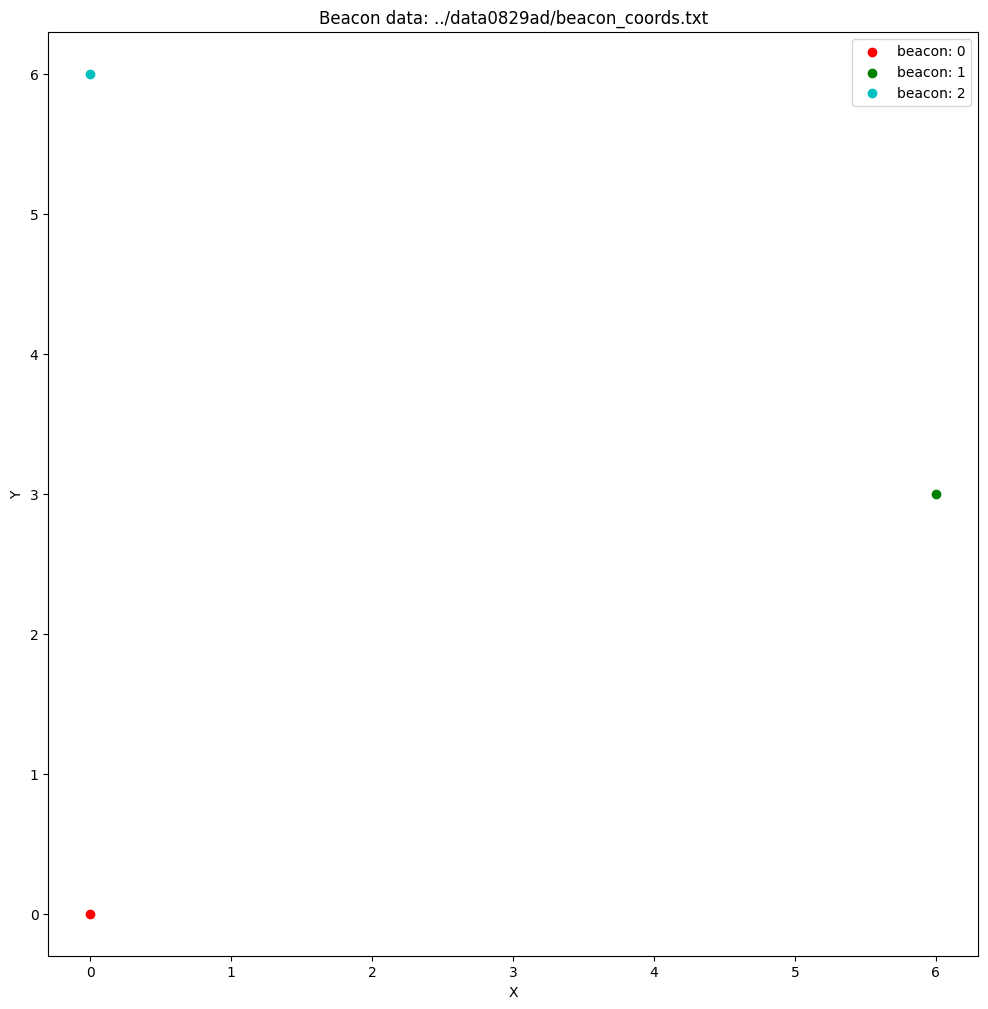

positions []


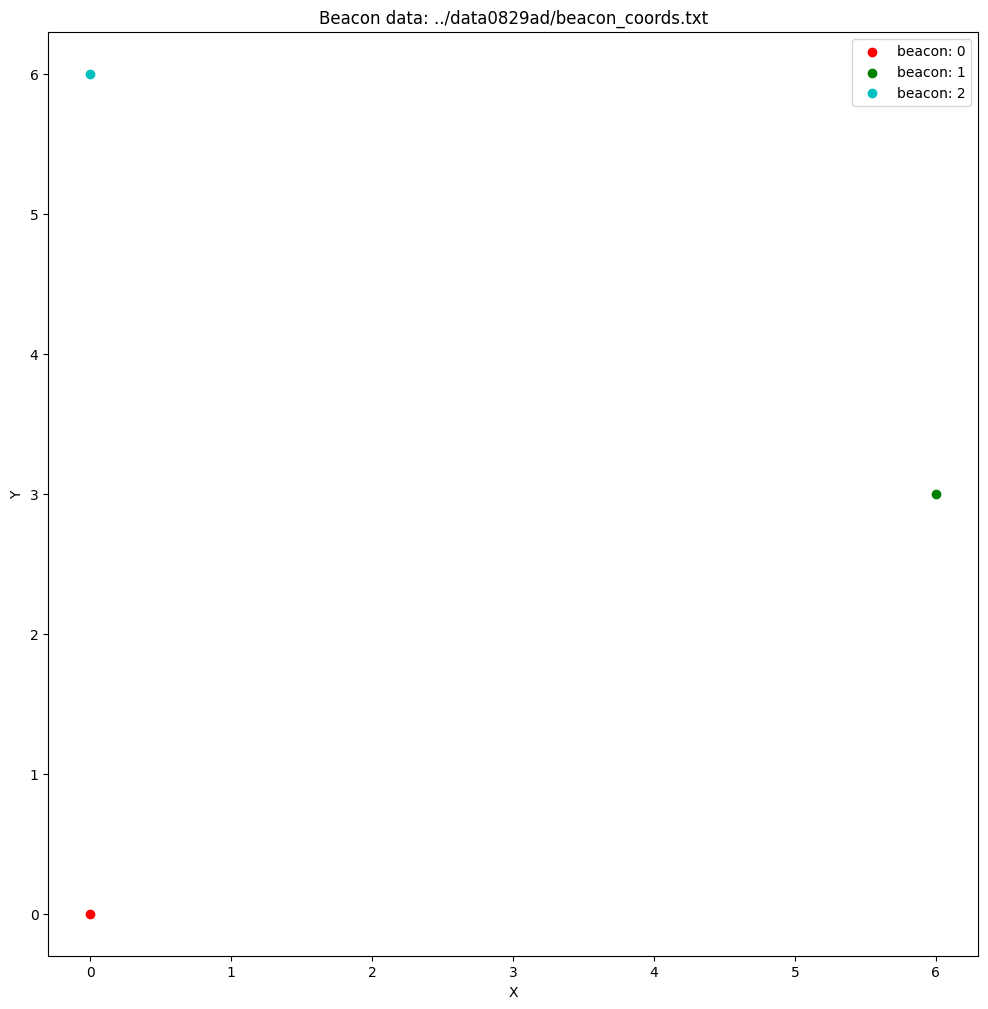

In [3]:
args = argparse.Namespace(beacon_coords_file='../data0829ad/beacon_coords.txt', beacon_data_dir='../data0829ad/', beacon_data_file='', update_frequency=10)


def aggregate_continuous_points(coordinates, n):
    """
    对每n个连续的坐标点进行聚合，并剔除离群点后得到统计代表点。
    
    coordinates: List of tuples/lists where each element is a (x, y) coordinate.
    n: Number of continuous points to group together.
    
    Returns:
    List of aggregated points (x, y).
    """
    aggregated_points = []

    for i in range(0, len(coordinates), n):
        # 提取每组n个连续的点
        group = [coord for coord in coordinates[i:i+n] if coord is not None]
        group = np.array(group)
        # 计算中位数和标准差
        median_x = np.median(group[:, 0])
        median_y = np.median(group[:, 1])
        std_x = np.std(group[:, 0])
        std_y = np.std(group[:, 1])

        # 设定阈值来剔除离群点
        threshold = 0.5
        filtered_group = []
        for coord in group:
            if (abs(coord[0] - median_x) < threshold * std_x) and (abs(coord[1] - median_y) < threshold * std_y):
                filtered_group.append(coord)

        filtered_group = np.array(filtered_group)

        # 如果过滤后有点，计算代表点
        if len(filtered_group) > 0:
            representative_point = np.mean(filtered_group, axis=0)
        else:
            # 如果所有点都被剔除了，可以使用中位数或者其他方式处理
            representative_point = np.mean(group, axis=0)
        
        aggregated_points.append(representative_point)

    return aggregated_points

for beacon_data_file in os.listdir(args.beacon_data_dir):
    if not beacon_data_file.endswith(".txt"):
        continue
    args.beacon_data_file = args.beacon_data_dir + beacon_data_file
    actual_coords = read_beacon_coords(args.beacon_coords_file)
    beacon_data = read_beacon_data(args.beacon_data_file)
    print("beacon data",beacon_data)
    print("beacon group num", len(beacon_data))

    positions = process_beacon_data_for_pos(args)
    positions = [pos[:3] for pos in positions if pos is not None]
    
    print("len positions", len(positions))
    
    
    colors = ['r', 'g', 'c', 'm', 'y', 'k', 'b']
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    file_num = [ str(num) for num in range(84, 88)]
    if file_num[0] in args.beacon_data_file or file_num[1] in args.beacon_data_file:
        plt.vlines(3, -1.6, 6, colors='g', linestyles='dashed', label='theory trajectory')
    if file_num[2] in args.beacon_data_file:
        x = np.linspace(0, 6, 100)
        y = x
        plt.plot(x, y, 'g--',label='theory trajectory')
    if file_num[3] in args.beacon_data_file:
        x = np.linspace(0, 6, 100)
        y = 6-x
        plt.plot(x, y, 'g--',label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Beacon data: {args.beacon_data_file}")
    plt.show()

    print("positions", positions)
    repre_positions = aggregate_continuous_points(positions, 3)
    
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(repre_positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    file_num = [ str(num) for num in range(84, 88)]
    if file_num[0] in args.beacon_data_file or file_num[1] in args.beacon_data_file:
        plt.vlines(3, -1.6, 6, colors='g', linestyles='dashed', label='theory trajectory')
    if file_num[2] in args.beacon_data_file:
        x = np.linspace(0, 6, 100)
        y = x
        plt.plot(x, y, 'g--',label='theory trajectory')
    if file_num[3] in args.beacon_data_file:
        x = np.linspace(0, 6, 100)
        y = 6-x
        plt.plot(x, y, 'g--',label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Beacon data: {args.beacon_data_file}")
    plt.show()
    
# print(args.beacon_data_file)


In [4]:
# # visualize the beacon RSSI to distance
# import matplotlib.pyplot as plt
# import numpy as np
# from collections import defaultdict
# import pdb


# def rssi_to_distance(rssi):
#     txPower = -55.47
#     n = 3.106
#     return 10 ** ((txPower - rssi) / (10 * n))

# beacon_id_to_rssi = defaultdict(list)
# time_stamp = []
# print(beacon_data)
# for beacon_group in beacon_data:
#     if len(beacon_group) < 3:
#         print("beacon group length is less than 3")
#         continue
#     for beacon in beacon_group:
#         beacon_id = beacon['uuid']
#         beacon_id_to_rssi[beacon_id].append(beacon['rssi'])
#     time_stamp.append(beacon['time'])

    
# for beacon_id, rssi_values in beacon_id_to_rssi.items():
#     if len(beacon_group[0]) <= 3:
#         print("beacon group length is less than 3")
#         continue
#     plt.figure(figsize=(12, 12))
#     distance = [rssi_to_distance(rssi) for rssi in rssi_values]
#     plt.plot(time_stamp, rssi_values, label='rssi to distance')
#     plt.xlabel('time(s)')
#     plt.ylabel('rssi')
#     plt.legend()
#     plt.title('beacon id: {}'.format(beacon_id))
#     plt.show()
    
#     plt.figure(figsize=(12, 12))
#     plt.plot(time_stamp, distance, label='rssi to distance')
#     plt.xlabel('time(s)')
#     plt.ylabel('distance(m)')
#     plt.title('beacon id: {}'.format(beacon_id))
#     plt.legend()
#     plt.show()
